1-3.3 Flatness v.s. Generalization Part 1


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)
tfm = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=tfm, download=True)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, transform=tfm)
train_loader_64   = torch.utils.data.DataLoader(train_dataset, batch_size=64,   shuffle=True,  num_workers=2, pin_memory=True)
train_loader_1024 = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True,  num_workers=2, pin_memory=True)
test_loader       = torch.utils.data.DataLoader(test_dataset,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
def train_model(model, optimizer, train_loader, num_epochs=5):
    model.to(device).train()
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs} | loss {total_loss/len(train_loader):.4f} | acc {100.0*correct/total:.2f}%")
    return model
@torch.no_grad()
def evaluate(model, loader):
    model.eval().to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_loss += loss_fn(outputs, labels).item()
        pred = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    avg_loss = total_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc
def interpolate_vector(alpha, theta1, theta2):
    return (1.0 - alpha) * theta1 + alpha * theta2
@torch.no_grad()
def run_interpolation(model_cls, theta1, theta2, alphas, train_loader_ref, test_loader_ref):
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for a in alphas:
        theta_a = interpolate_vector(a, theta1, theta2)
        m = model_cls().to(device)
        torch.nn.utils.vector_to_parameters(theta_a, m.parameters())
        tr_loss, tr_acc = evaluate(m, train_loader_ref)
        te_loss, te_acc = evaluate(m, test_loader_ref)
        train_losses.append(tr_loss)
        test_losses.append(te_loss)
        train_accs.append(tr_acc)
        test_accs.append(te_acc)
    return (np.array(train_losses), np.array(test_losses),
            np.array(train_accs),  np.array(test_accs))
def plot_interpolation(alphas, tr_loss, te_loss, tr_acc, te_acc, title, filename):
    fig, ax1 = plt.subplots(figsize=(7.2, 4.8))

    eps = 1e-8
    ax1.set_xlabel('Interpolation ratio α')
    ax1.set_ylabel('Cross-entropy (log scale)', color='tab:blue')
    h1, = ax1.plot(alphas, np.log(tr_loss + eps), '--', lw=2, label='Train loss (log)', color='tab:blue')
    h2, = ax1.plot(alphas, np.log(te_loss + eps), '-',  lw=2, label='Test loss (log)',  color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:red')
    h3, = ax2.plot(alphas, tr_acc, '--', lw=2, label='Train acc', color='tab:red')
    h4, = ax2.plot(alphas, te_acc, '-',  lw=2, label='Test acc',  color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    lines = [h1, h2, h3, h4]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')
    ax1.axvline(0.0, color='gray', alpha=0.25, lw=1)
    ax1.axvline(1.0, color='gray', alpha=0.25, lw=1)
    ax1.grid(alpha=0.15, linestyle='--')
    plt.title(title)
    plt.tight_layout()

    
    png_path = os.path.join("results", filename + ".png")
    pdf_path = os.path.join("results", filename + ".pdf")
    plt.savefig(png_path, dpi=150)
    plt.savefig(pdf_path)
    plt.close()
    print(f"Saved: {png_path}, {pdf_path}")


def train_pair_and_interpolate(lr, epochs=5):
    print(f"\n=== Training pair with LR={lr} | bs 64 vs 1024 ===")
    
    mA = SimpleModel()
    optA = torch.optim.Adam(mA.parameters(), lr=lr)
    mA = train_model(mA, optA, train_loader_64, num_epochs=epochs)

    
    mB = SimpleModel()
    optB = torch.optim.Adam(mB.parameters(), lr=lr)
    mB = train_model(mB, optB, train_loader_1024, num_epochs=epochs)

    
    with torch.no_grad():
        thetaA = torch.nn.utils.parameters_to_vector(mA.cpu().parameters()).detach()
        thetaB = torch.nn.utils.parameters_to_vector(mB.cpu().parameters()).detach()

    
    alphas = np.linspace(-1.0, 2.0, 31)


    trL, teL, trA, teA = run_interpolation(SimpleModel, thetaA.to(device), thetaB.to(device),
                                           alphas, train_loader_64, test_loader)
    title = f'Linear Interpolation (bs=64 vs 1024, Adam, LR={lr})'
    fname = f'interpolation_lr{lr}'
    plot_interpolation(alphas, trL, teL, trA, teA, title, fname)


train_pair_and_interpolate(lr=1e-2, epochs=5)
train_pair_and_interpolate(lr=1e-3, epochs=5)



=== Training pair with LR=0.01 | bs 64 vs 1024 ===
Epoch 1/5 | loss 0.2597 | acc 92.29%
Epoch 2/5 | loss 0.1544 | acc 95.85%
Epoch 3/5 | loss 0.1409 | acc 96.19%
Epoch 4/5 | loss 0.1186 | acc 96.84%
Epoch 5/5 | loss 0.1149 | acc 96.99%
Epoch 1/5 | loss 0.3943 | acc 87.23%
Epoch 2/5 | loss 0.0984 | acc 97.00%
Epoch 3/5 | loss 0.0708 | acc 97.74%
Epoch 4/5 | loss 0.0514 | acc 98.42%
Epoch 5/5 | loss 0.0358 | acc 98.83%
Saved: results/interpolation_lr0.01.png, results/interpolation_lr0.01.pdf

=== Training pair with LR=0.001 | bs 64 vs 1024 ===
Epoch 1/5 | loss 0.2386 | acc 92.97%
Epoch 2/5 | loss 0.0875 | acc 97.33%
Epoch 3/5 | loss 0.0579 | acc 98.17%
Epoch 4/5 | loss 0.0425 | acc 98.62%
Epoch 5/5 | loss 0.0338 | acc 98.93%
Epoch 1/5 | loss 0.6593 | acc 84.25%
Epoch 2/5 | loss 0.2345 | acc 93.21%
Epoch 3/5 | loss 0.1698 | acc 95.16%
Epoch 4/5 | loss 0.1307 | acc 96.17%
Epoch 5/5 | loss 0.1030 | acc 97.00%
Saved: results/interpolation_lr0.001.png, results/interpolation_lr0.001.pdf


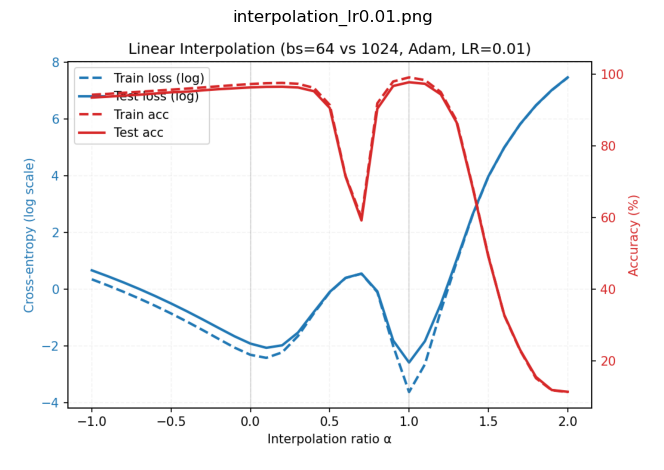

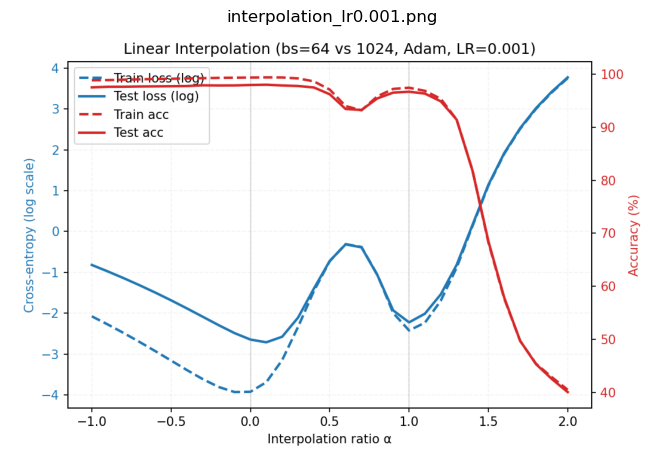

In [4]:
def show_result(name_without_ext):
    """Example: show_result('interpolation_lr0.001')"""
    import os, matplotlib.pyplot as plt
    path = os.path.join("results", name_without_ext + ".png")
    img = plt.imread(path)
    plt.figure(figsize=(7.2, 4.8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.tight_layout()
    plt.show()

# Example:
show_result('interpolation_lr0.01')
show_result('interpolation_lr0.001')
